In [133]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [134]:
# learning parameters
batch_size = 128
epochs = 200
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [135]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs2

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file input already exists.
Error occurred while processing: input.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file outputs2 already exists.
Error occurred while processing: outputs2.


# Generator

In [136]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [137]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [138]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [139]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [140]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [141]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [142]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [143]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [144]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [145]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

In [146]:
import torch.nn.init as init

# Define a custom weight initialization function
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        # Initialize weights to a normal distribution
        init.normal_(m.weight.data, 0.0, std=0.01)
        init.constant_(m.bias.data, 0.0)

# Apply normal distribution initialization to the generator and discriminator
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)


Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

# Q. Write training loop

469it [00:20, 22.46it/s]                         


Epoch 1 of 200
Generator loss: 1.01624333, Discriminator loss: 1.17476104


469it [00:20, 23.17it/s]                         


Epoch 2 of 200
Generator loss: 1.34729797, Discriminator loss: 1.11234040


469it [00:19, 23.79it/s]                         


Epoch 3 of 200
Generator loss: 1.39073973, Discriminator loss: 1.12785079


469it [00:20, 22.86it/s]                         


Epoch 4 of 200
Generator loss: 1.50707506, Discriminator loss: 1.14409290


469it [00:20, 23.24it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


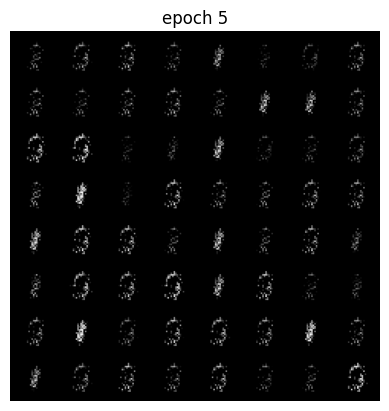

Epoch 5 of 200
Generator loss: 1.73989343, Discriminator loss: 0.91469141


469it [00:20, 22.63it/s]                         


Epoch 6 of 200
Generator loss: 2.68722399, Discriminator loss: 0.76275116


469it [00:20, 22.65it/s]                         


Epoch 7 of 200
Generator loss: 2.77902146, Discriminator loss: 0.65551946


469it [00:20, 22.54it/s]                         


Epoch 8 of 200
Generator loss: 2.48273645, Discriminator loss: 0.67937126


469it [00:20, 22.77it/s]                         


Epoch 9 of 200
Generator loss: 2.48372417, Discriminator loss: 0.66234157


469it [00:21, 21.85it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


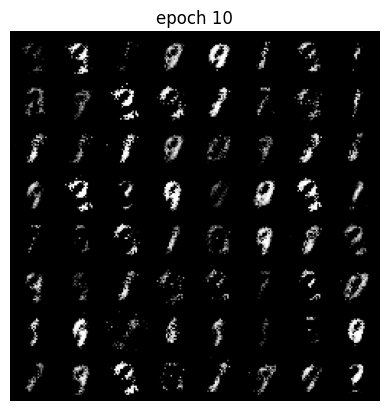

Epoch 10 of 200
Generator loss: 2.58724555, Discriminator loss: 0.60220183


469it [00:21, 22.28it/s]                         


Epoch 11 of 200
Generator loss: 2.94540126, Discriminator loss: 0.48747720


469it [00:20, 22.51it/s]                         


Epoch 12 of 200
Generator loss: 3.10180127, Discriminator loss: 0.48660980


469it [00:20, 22.55it/s]                         


Epoch 13 of 200
Generator loss: 2.81671800, Discriminator loss: 0.54419347


469it [00:22, 21.27it/s]                         


Epoch 14 of 200
Generator loss: 2.81705613, Discriminator loss: 0.53225604


469it [00:21, 22.04it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


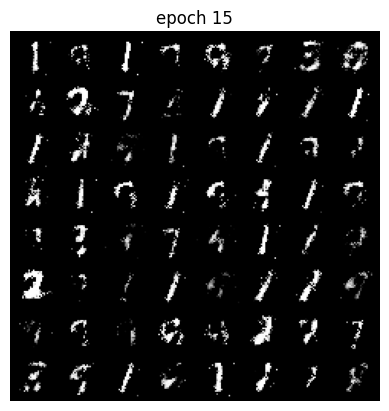

Epoch 15 of 200
Generator loss: 2.66006846, Discriminator loss: 0.56018455


469it [00:22, 20.76it/s]                         


Epoch 16 of 200
Generator loss: 2.60245427, Discriminator loss: 0.55852636


469it [00:21, 21.43it/s]                         


Epoch 17 of 200
Generator loss: 2.47288086, Discriminator loss: 0.57246517


469it [00:21, 21.55it/s]                         


Epoch 18 of 200
Generator loss: 2.45386035, Discriminator loss: 0.58853296


469it [00:21, 22.08it/s]                         


Epoch 19 of 200
Generator loss: 2.26537929, Discriminator loss: 0.64472340


469it [00:21, 22.29it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


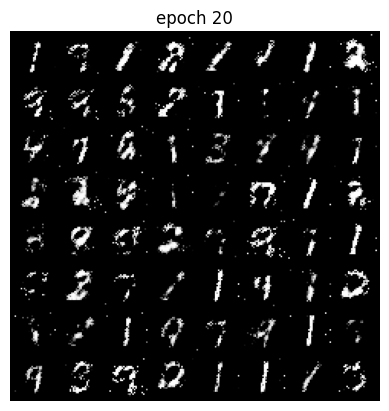

Epoch 20 of 200
Generator loss: 2.25222015, Discriminator loss: 0.64984290


469it [00:21, 21.33it/s]                         


Epoch 21 of 200
Generator loss: 2.21144503, Discriminator loss: 0.67632952


469it [00:21, 21.33it/s]                         


Epoch 22 of 200
Generator loss: 2.23689426, Discriminator loss: 0.65983788


469it [00:20, 22.59it/s]                         


Epoch 23 of 200
Generator loss: 2.03927617, Discriminator loss: 0.72485277


469it [00:21, 21.32it/s]                         


Epoch 24 of 200
Generator loss: 2.00313789, Discriminator loss: 0.71797463


469it [00:22, 21.11it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


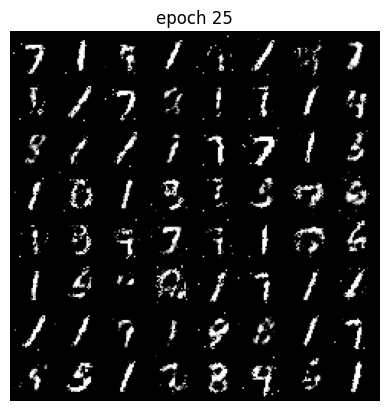

Epoch 25 of 200
Generator loss: 2.03675200, Discriminator loss: 0.72087250


469it [00:21, 21.97it/s]                         


Epoch 26 of 200
Generator loss: 2.00732911, Discriminator loss: 0.73330540


469it [00:21, 21.41it/s]                         


Epoch 27 of 200
Generator loss: 1.89469377, Discriminator loss: 0.78502174


469it [00:21, 22.13it/s]                         


Epoch 28 of 200
Generator loss: 1.85696651, Discriminator loss: 0.80597721


469it [00:21, 22.07it/s]                         


Epoch 29 of 200
Generator loss: 1.87896332, Discriminator loss: 0.80816352


469it [00:20, 22.37it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


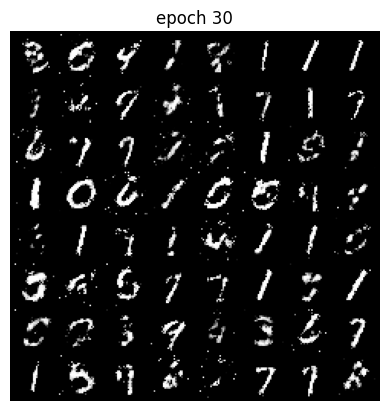

Epoch 30 of 200
Generator loss: 1.80156548, Discriminator loss: 0.82040586


469it [00:21, 21.34it/s]                         


Epoch 31 of 200
Generator loss: 1.78132173, Discriminator loss: 0.83406477


469it [00:23, 19.58it/s]                         


Epoch 32 of 200
Generator loss: 1.77934653, Discriminator loss: 0.83377389


469it [00:23, 20.17it/s]                         


Epoch 33 of 200
Generator loss: 1.78260053, Discriminator loss: 0.83813763


469it [00:21, 21.52it/s]                         


Epoch 34 of 200
Generator loss: 1.69759519, Discriminator loss: 0.87826985


469it [00:20, 22.34it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


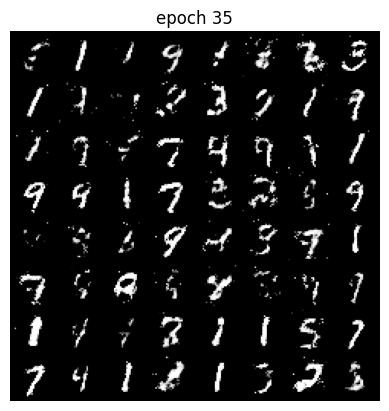

Epoch 35 of 200
Generator loss: 1.64954431, Discriminator loss: 0.88290474


469it [00:21, 21.54it/s]                         


Epoch 36 of 200
Generator loss: 1.65474770, Discriminator loss: 0.89090461


469it [00:21, 22.33it/s]                         


Epoch 37 of 200
Generator loss: 1.65140854, Discriminator loss: 0.88615547


469it [00:20, 22.46it/s]                         


Epoch 38 of 200
Generator loss: 1.62779315, Discriminator loss: 0.88878227


469it [00:20, 22.48it/s]                         


Epoch 39 of 200
Generator loss: 1.56821710, Discriminator loss: 0.92885890


469it [00:20, 22.60it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


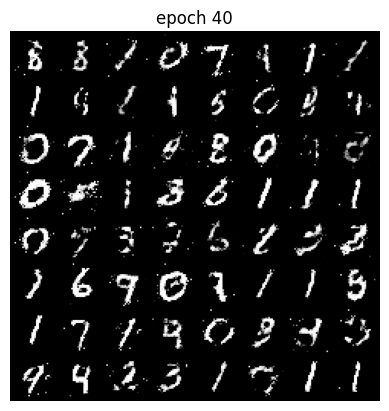

Epoch 40 of 200
Generator loss: 1.52935722, Discriminator loss: 0.94659552


469it [00:21, 22.25it/s]                         


Epoch 41 of 200
Generator loss: 1.49539040, Discriminator loss: 0.96129492


469it [00:20, 22.48it/s]                         


Epoch 42 of 200
Generator loss: 1.47426260, Discriminator loss: 0.96334707


469it [00:21, 21.45it/s]                         


Epoch 43 of 200
Generator loss: 1.46919660, Discriminator loss: 0.97833595


469it [00:21, 21.60it/s]                         


Epoch 44 of 200
Generator loss: 1.43915790, Discriminator loss: 0.98588099


469it [00:20, 22.65it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


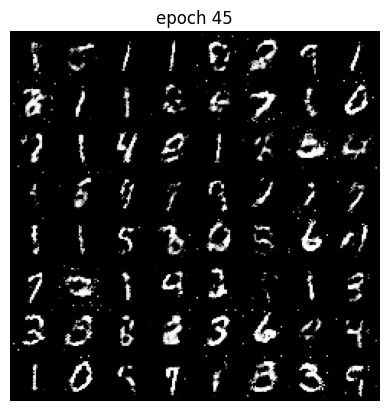

Epoch 45 of 200
Generator loss: 1.43714733, Discriminator loss: 0.99169665


469it [00:20, 22.70it/s]                         


Epoch 46 of 200
Generator loss: 1.40559891, Discriminator loss: 1.00027343


469it [00:20, 22.64it/s]                         


Epoch 47 of 200
Generator loss: 1.42820247, Discriminator loss: 1.00447844


469it [00:20, 22.64it/s]                         


Epoch 48 of 200
Generator loss: 1.36898642, Discriminator loss: 1.02111490


469it [00:20, 22.41it/s]                         


Epoch 49 of 200
Generator loss: 1.37480357, Discriminator loss: 1.01904680


469it [00:20, 22.46it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


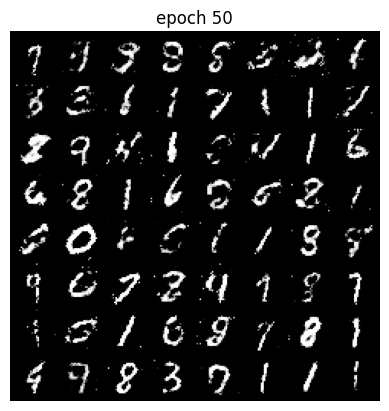

Epoch 50 of 200
Generator loss: 1.35279112, Discriminator loss: 1.02019282


469it [00:20, 22.43it/s]                         


Epoch 51 of 200
Generator loss: 1.34074657, Discriminator loss: 1.03573139


469it [00:20, 22.51it/s]                         


Epoch 52 of 200
Generator loss: 1.32237568, Discriminator loss: 1.04682651


469it [00:21, 22.32it/s]                         


Epoch 53 of 200
Generator loss: 1.33310843, Discriminator loss: 1.04018423


469it [00:20, 22.44it/s]                         


Epoch 54 of 200
Generator loss: 1.32614112, Discriminator loss: 1.04393263


469it [00:21, 22.02it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


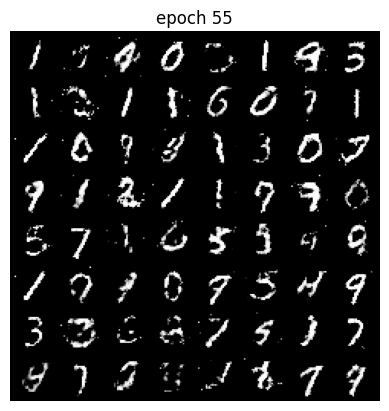

Epoch 55 of 200
Generator loss: 1.29935356, Discriminator loss: 1.05220819


469it [00:20, 22.63it/s]                         


Epoch 56 of 200
Generator loss: 1.30002592, Discriminator loss: 1.06206144


469it [00:21, 21.79it/s]                         


Epoch 57 of 200
Generator loss: 1.26737155, Discriminator loss: 1.07703537


469it [00:21, 22.00it/s]                         


Epoch 58 of 200
Generator loss: 1.26443672, Discriminator loss: 1.07806443


469it [00:21, 22.19it/s]                         


Epoch 59 of 200
Generator loss: 1.26852795, Discriminator loss: 1.07721185


469it [00:20, 23.44it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


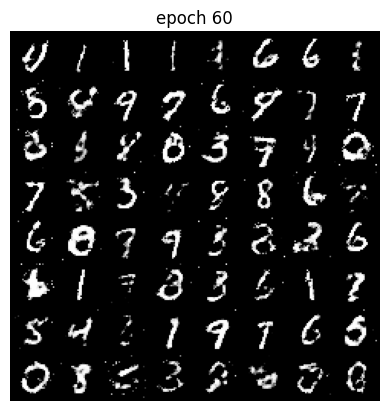

Epoch 60 of 200
Generator loss: 1.27256238, Discriminator loss: 1.07442228


469it [00:20, 22.99it/s]                         


Epoch 61 of 200
Generator loss: 1.21969641, Discriminator loss: 1.09763184


469it [00:20, 23.32it/s]                         


Epoch 62 of 200
Generator loss: 1.27147686, Discriminator loss: 1.08321042


469it [00:21, 22.05it/s]                         


Epoch 63 of 200
Generator loss: 1.22748095, Discriminator loss: 1.09495770


469it [00:21, 22.12it/s]                         


Epoch 64 of 200
Generator loss: 1.22154376, Discriminator loss: 1.09854417


469it [00:21, 21.58it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


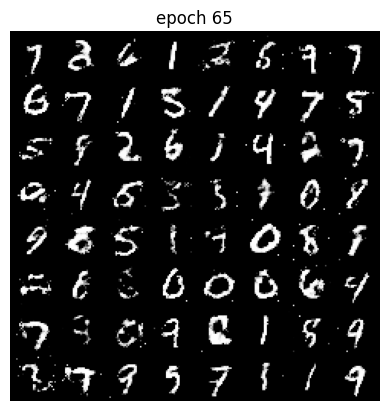

Epoch 65 of 200
Generator loss: 1.21716874, Discriminator loss: 1.10281201


469it [00:21, 21.35it/s]                         


Epoch 66 of 200
Generator loss: 1.20476262, Discriminator loss: 1.10928498


469it [00:21, 22.26it/s]                         


Epoch 67 of 200
Generator loss: 1.20431095, Discriminator loss: 1.10951437


469it [00:20, 23.19it/s]                         


Epoch 68 of 200
Generator loss: 1.22312566, Discriminator loss: 1.10208221


469it [00:20, 22.92it/s]                         


Epoch 69 of 200
Generator loss: 1.19246348, Discriminator loss: 1.11654102


469it [00:20, 23.22it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


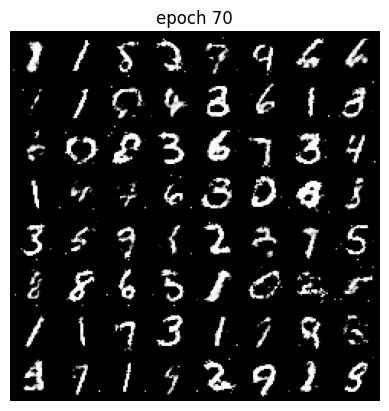

Epoch 70 of 200
Generator loss: 1.18466304, Discriminator loss: 1.11811247


469it [00:20, 22.50it/s]                         


Epoch 71 of 200
Generator loss: 1.19132661, Discriminator loss: 1.11454849


469it [00:19, 23.68it/s]                         


Epoch 72 of 200
Generator loss: 1.17111833, Discriminator loss: 1.12446963


469it [00:21, 22.13it/s]                         


Epoch 73 of 200
Generator loss: 1.14389360, Discriminator loss: 1.13442033


469it [00:20, 23.26it/s]                         


Epoch 74 of 200
Generator loss: 1.17806947, Discriminator loss: 1.12582784


469it [00:24, 19.46it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


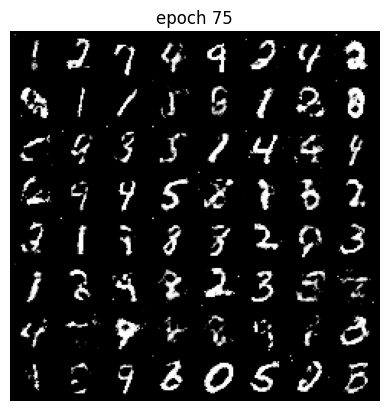

Epoch 75 of 200
Generator loss: 1.17721588, Discriminator loss: 1.12321118


469it [00:20, 23.34it/s]                         


Epoch 76 of 200
Generator loss: 1.16096828, Discriminator loss: 1.13147180


469it [00:19, 23.93it/s]                         


Epoch 77 of 200
Generator loss: 1.13821408, Discriminator loss: 1.14628883


469it [00:19, 23.56it/s]                         


Epoch 78 of 200
Generator loss: 1.14903375, Discriminator loss: 1.13898274


469it [00:20, 22.57it/s]                         


Epoch 79 of 200
Generator loss: 1.12794406, Discriminator loss: 1.14519529


469it [00:20, 22.86it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


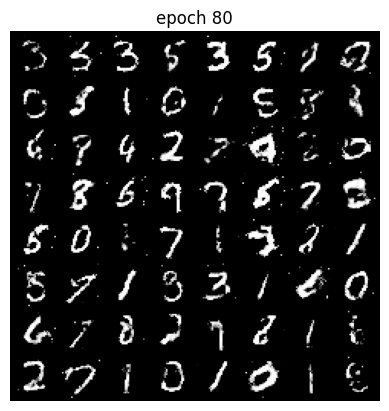

Epoch 80 of 200
Generator loss: 1.12789397, Discriminator loss: 1.14183278


469it [00:20, 22.79it/s]                         


Epoch 81 of 200
Generator loss: 1.13734351, Discriminator loss: 1.14895919


469it [00:20, 22.48it/s]                         


Epoch 82 of 200
Generator loss: 1.12006289, Discriminator loss: 1.15018359


469it [00:21, 22.04it/s]                         


Epoch 83 of 200
Generator loss: 1.11721080, Discriminator loss: 1.15088820


469it [00:21, 21.97it/s]                         


Epoch 84 of 200
Generator loss: 1.12971081, Discriminator loss: 1.14421644


469it [00:21, 22.03it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


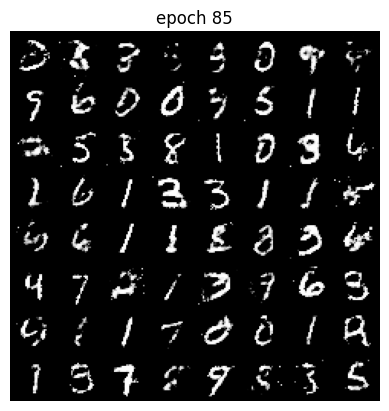

Epoch 85 of 200
Generator loss: 1.11423653, Discriminator loss: 1.15533431


469it [00:21, 22.01it/s]                         


Epoch 86 of 200
Generator loss: 1.12038723, Discriminator loss: 1.15254066


469it [00:21, 22.27it/s]                         


Epoch 87 of 200
Generator loss: 1.11858100, Discriminator loss: 1.15441290


469it [00:21, 22.09it/s]                         


Epoch 88 of 200
Generator loss: 1.13476532, Discriminator loss: 1.15166085


469it [00:21, 22.21it/s]                         


Epoch 89 of 200
Generator loss: 1.09942523, Discriminator loss: 1.15810411


469it [00:21, 22.18it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


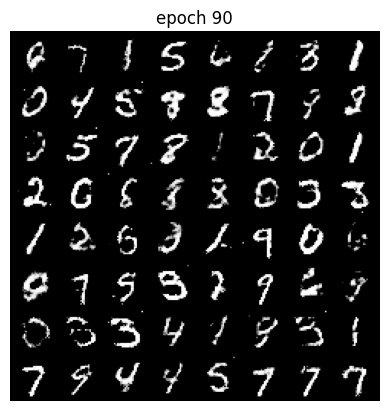

Epoch 90 of 200
Generator loss: 1.12471058, Discriminator loss: 1.14975921


469it [00:21, 22.26it/s]                         


Epoch 91 of 200
Generator loss: 1.10441770, Discriminator loss: 1.15625874


469it [00:21, 22.14it/s]                         


Epoch 92 of 200
Generator loss: 1.11064563, Discriminator loss: 1.16176982


469it [00:21, 22.27it/s]                         


Epoch 93 of 200
Generator loss: 1.09867939, Discriminator loss: 1.15641161


469it [00:20, 22.34it/s]                         


Epoch 94 of 200
Generator loss: 1.09378717, Discriminator loss: 1.16844873


469it [00:20, 22.41it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


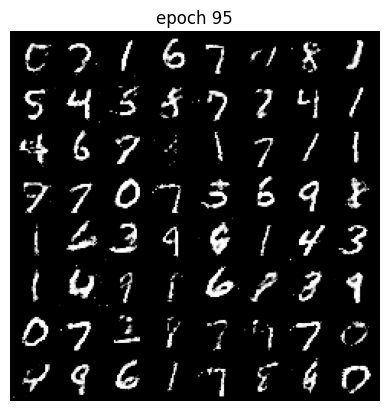

Epoch 95 of 200
Generator loss: 1.08791961, Discriminator loss: 1.17205616


469it [00:21, 22.21it/s]                         


Epoch 96 of 200
Generator loss: 1.08343415, Discriminator loss: 1.16887324


469it [00:21, 21.60it/s]                         


Epoch 97 of 200
Generator loss: 1.09908322, Discriminator loss: 1.16402766


469it [00:21, 21.55it/s]                         


Epoch 98 of 200
Generator loss: 1.11753298, Discriminator loss: 1.16053602


469it [00:21, 21.75it/s]                         


Epoch 99 of 200
Generator loss: 1.08480132, Discriminator loss: 1.16590147


469it [00:21, 21.93it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


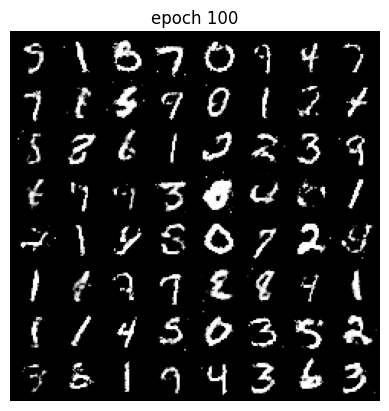

Epoch 100 of 200
Generator loss: 1.07643741, Discriminator loss: 1.17760045


469it [00:21, 22.21it/s]                         


Epoch 101 of 200
Generator loss: 1.08892067, Discriminator loss: 1.17504825


469it [00:21, 21.90it/s]                         


Epoch 102 of 200
Generator loss: 1.09146257, Discriminator loss: 1.16983522


469it [00:21, 21.43it/s]                         


Epoch 103 of 200
Generator loss: 1.07959617, Discriminator loss: 1.17412214


469it [00:21, 21.53it/s]                         


Epoch 104 of 200
Generator loss: 1.06410614, Discriminator loss: 1.17945703


469it [00:21, 21.73it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


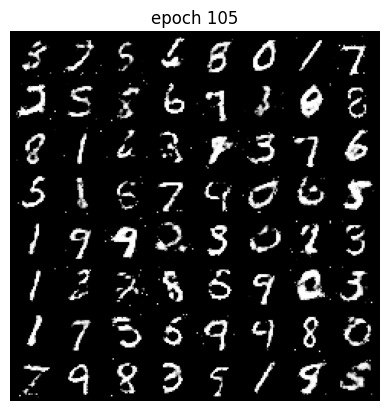

Epoch 105 of 200
Generator loss: 1.07349654, Discriminator loss: 1.17402627


469it [00:21, 21.83it/s]                         


Epoch 106 of 200
Generator loss: 1.08019632, Discriminator loss: 1.17843050


469it [00:21, 21.80it/s]                         


Epoch 107 of 200
Generator loss: 1.06937716, Discriminator loss: 1.18009340


469it [00:22, 21.20it/s]                         


Epoch 108 of 200
Generator loss: 1.07116606, Discriminator loss: 1.18263992


469it [00:21, 21.33it/s]                         


Epoch 109 of 200
Generator loss: 1.06979823, Discriminator loss: 1.18244657


469it [00:21, 21.43it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


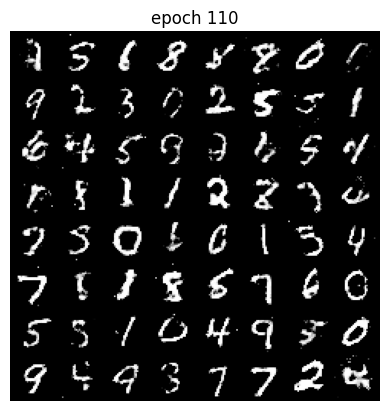

Epoch 110 of 200
Generator loss: 1.07152845, Discriminator loss: 1.17807642


469it [00:21, 22.09it/s]                         


Epoch 111 of 200
Generator loss: 1.07047809, Discriminator loss: 1.18333084


469it [00:21, 22.21it/s]                         


Epoch 112 of 200
Generator loss: 1.07448005, Discriminator loss: 1.17935893


469it [00:21, 21.86it/s]                         


Epoch 113 of 200
Generator loss: 1.05675081, Discriminator loss: 1.18797809


469it [00:20, 22.59it/s]                         


Epoch 114 of 200
Generator loss: 1.04194933, Discriminator loss: 1.18807004


469it [00:20, 23.07it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


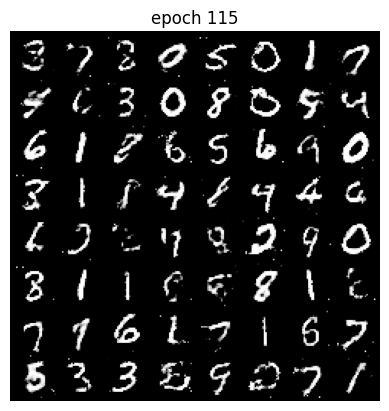

Epoch 115 of 200
Generator loss: 1.04925350, Discriminator loss: 1.18832307


469it [00:20, 23.44it/s]                         


Epoch 116 of 200
Generator loss: 1.06151771, Discriminator loss: 1.18407754


469it [00:20, 23.39it/s]                         


Epoch 117 of 200
Generator loss: 1.06331283, Discriminator loss: 1.18704626


469it [00:20, 23.10it/s]                         


Epoch 118 of 200
Generator loss: 1.05344482, Discriminator loss: 1.19176235


469it [00:20, 23.14it/s]                         


Epoch 119 of 200
Generator loss: 1.06467393, Discriminator loss: 1.18878196


469it [00:20, 22.88it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


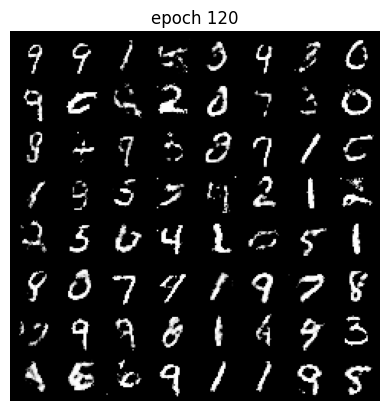

Epoch 120 of 200
Generator loss: 1.05083166, Discriminator loss: 1.19070415


469it [00:20, 22.94it/s]                         


Epoch 121 of 200
Generator loss: 1.04485267, Discriminator loss: 1.19152153


469it [00:20, 22.70it/s]                         


Epoch 122 of 200
Generator loss: 1.07700236, Discriminator loss: 1.18508898


469it [00:20, 22.73it/s]                         


Epoch 123 of 200
Generator loss: 1.05265877, Discriminator loss: 1.19070485


469it [00:20, 22.72it/s]                         


Epoch 124 of 200
Generator loss: 1.06032132, Discriminator loss: 1.18838188


469it [00:20, 23.34it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


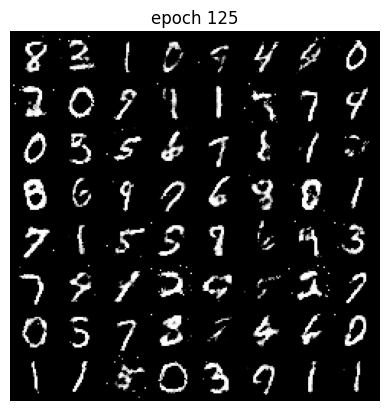

Epoch 125 of 200
Generator loss: 1.06740278, Discriminator loss: 1.18682151


469it [00:20, 23.44it/s]                         


Epoch 126 of 200
Generator loss: 1.05859123, Discriminator loss: 1.19159789


469it [00:19, 23.46it/s]                         


Epoch 127 of 200
Generator loss: 1.03992830, Discriminator loss: 1.19384211


469it [00:19, 23.57it/s]                         


Epoch 128 of 200
Generator loss: 1.05214183, Discriminator loss: 1.18915524


469it [00:19, 23.50it/s]                         


Epoch 129 of 200
Generator loss: 1.06161754, Discriminator loss: 1.19197240


469it [00:19, 23.61it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


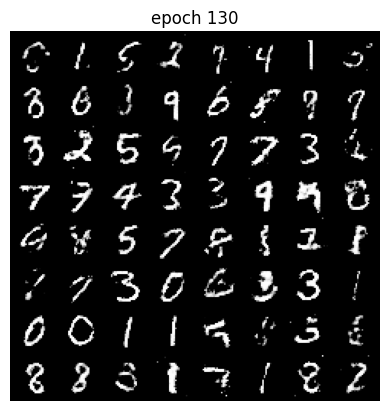

Epoch 130 of 200
Generator loss: 1.03814614, Discriminator loss: 1.20037183


469it [00:19, 23.54it/s]                         


Epoch 131 of 200
Generator loss: 1.05181223, Discriminator loss: 1.19095262


469it [00:19, 23.68it/s]                         


Epoch 132 of 200
Generator loss: 1.07766805, Discriminator loss: 1.18860728


469it [00:19, 23.76it/s]                         


Epoch 133 of 200
Generator loss: 1.04615192, Discriminator loss: 1.19948617


469it [00:19, 23.70it/s]                         


Epoch 134 of 200
Generator loss: 1.04656687, Discriminator loss: 1.19529245


469it [00:19, 23.60it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


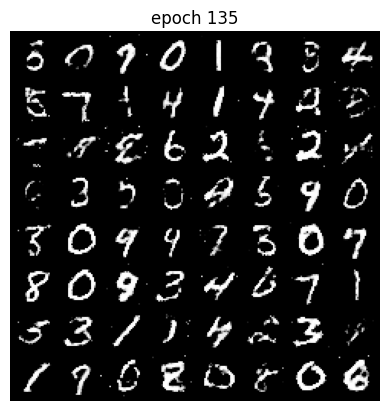

Epoch 135 of 200
Generator loss: 1.04433051, Discriminator loss: 1.19536615


469it [00:19, 23.56it/s]                         


Epoch 136 of 200
Generator loss: 1.04313214, Discriminator loss: 1.19444968


469it [00:19, 23.62it/s]                         


Epoch 137 of 200
Generator loss: 1.03737124, Discriminator loss: 1.19694342


469it [00:19, 23.50it/s]                         


Epoch 138 of 200
Generator loss: 1.05274094, Discriminator loss: 1.19475780


469it [00:19, 23.62it/s]                         


Epoch 139 of 200
Generator loss: 1.04927508, Discriminator loss: 1.19701738


469it [00:43, 10.86it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


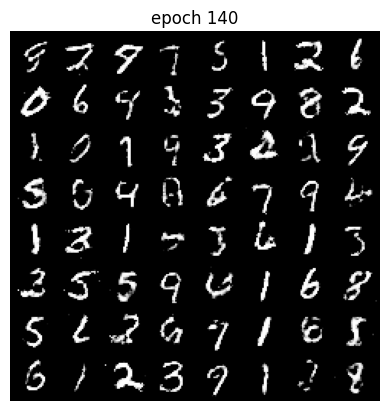

Epoch 140 of 200
Generator loss: 1.02355023, Discriminator loss: 1.20385700


469it [00:21, 21.94it/s]                         


Epoch 141 of 200
Generator loss: 1.04243523, Discriminator loss: 1.19921269


469it [00:21, 22.03it/s]                         


Epoch 142 of 200
Generator loss: 1.03831224, Discriminator loss: 1.19753320


469it [00:21, 22.02it/s]                         


Epoch 143 of 200
Generator loss: 1.04717187, Discriminator loss: 1.20213961


469it [00:20, 22.59it/s]                         


Epoch 144 of 200
Generator loss: 1.05261203, Discriminator loss: 1.19797387


469it [00:20, 23.42it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


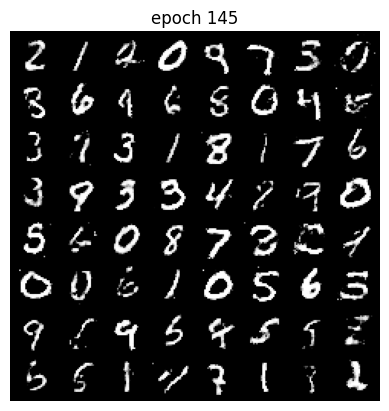

Epoch 145 of 200
Generator loss: 1.04892239, Discriminator loss: 1.19799761


469it [00:20, 23.33it/s]                         


Epoch 146 of 200
Generator loss: 1.04042406, Discriminator loss: 1.19872125


469it [00:19, 23.60it/s]                         


Epoch 147 of 200
Generator loss: 1.05241225, Discriminator loss: 1.19609669


469it [00:19, 23.68it/s]                         


Epoch 148 of 200
Generator loss: 1.04650163, Discriminator loss: 1.19848615


469it [00:19, 23.64it/s]                         


Epoch 149 of 200
Generator loss: 1.03317905, Discriminator loss: 1.20097891


469it [00:20, 23.41it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


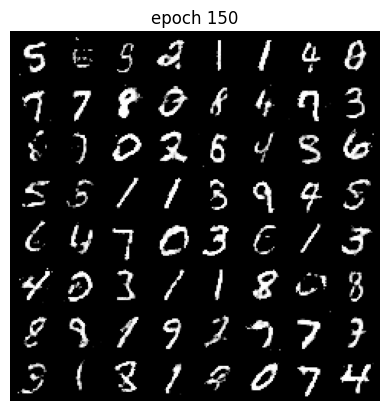

Epoch 150 of 200
Generator loss: 1.03073060, Discriminator loss: 1.20856064


469it [00:19, 23.52it/s]                         


Epoch 151 of 200
Generator loss: 1.05994958, Discriminator loss: 1.20110492


469it [00:20, 23.42it/s]                         


Epoch 152 of 200
Generator loss: 1.04626119, Discriminator loss: 1.20011730


469it [00:19, 23.52it/s]                         


Epoch 153 of 200
Generator loss: 1.01755599, Discriminator loss: 1.20581660


469it [00:19, 23.55it/s]                         


Epoch 154 of 200
Generator loss: 1.02929593, Discriminator loss: 1.20339613


469it [00:19, 23.59it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


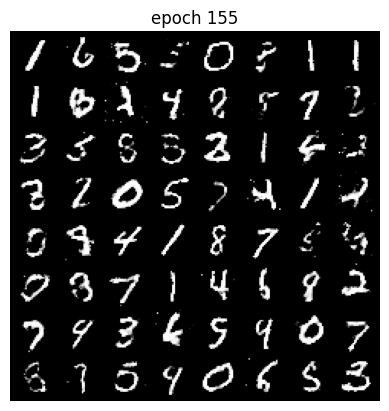

Epoch 155 of 200
Generator loss: 1.04474897, Discriminator loss: 1.19871093


469it [00:19, 23.69it/s]                         


Epoch 156 of 200
Generator loss: 1.03412167, Discriminator loss: 1.20356974


469it [00:19, 23.64it/s]                         


Epoch 157 of 200
Generator loss: 1.04855493, Discriminator loss: 1.20336840


469it [00:19, 23.45it/s]                         


Epoch 158 of 200
Generator loss: 1.06119290, Discriminator loss: 1.19954414


469it [00:19, 23.50it/s]                         


Epoch 159 of 200
Generator loss: 1.02257512, Discriminator loss: 1.20670836


469it [00:19, 23.60it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


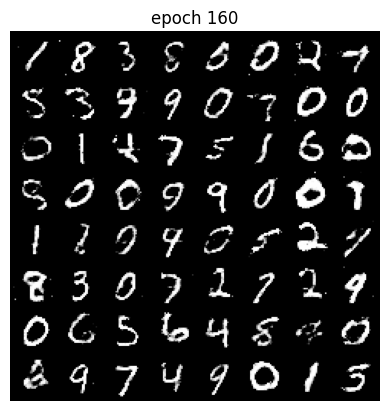

Epoch 160 of 200
Generator loss: 1.03650774, Discriminator loss: 1.19934491


469it [00:19, 23.60it/s]                         


Epoch 161 of 200
Generator loss: 1.03280925, Discriminator loss: 1.19967393


469it [00:19, 23.69it/s]                         


Epoch 162 of 200
Generator loss: 1.03216237, Discriminator loss: 1.20200122


469it [00:19, 23.62it/s]                         


Epoch 163 of 200
Generator loss: 1.02360853, Discriminator loss: 1.20427103


469it [00:19, 23.62it/s]                         


Epoch 164 of 200
Generator loss: 1.04220777, Discriminator loss: 1.19913420


469it [00:19, 23.65it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


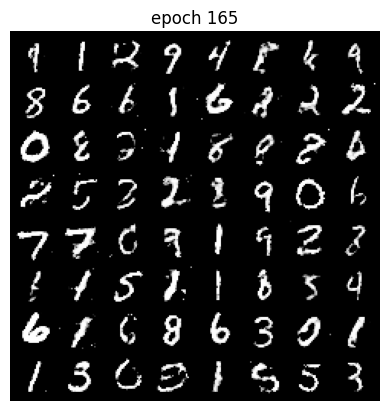

Epoch 165 of 200
Generator loss: 1.03083301, Discriminator loss: 1.20168973


469it [00:19, 23.62it/s]                         


Epoch 166 of 200
Generator loss: 1.04026962, Discriminator loss: 1.19919854


469it [00:19, 23.68it/s]                         


Epoch 167 of 200
Generator loss: 1.05354631, Discriminator loss: 1.19871700


469it [00:19, 23.73it/s]                         


Epoch 168 of 200
Generator loss: 1.04993644, Discriminator loss: 1.19953181


469it [00:19, 23.74it/s]                         


Epoch 169 of 200
Generator loss: 1.03824897, Discriminator loss: 1.20445723


469it [00:19, 23.81it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


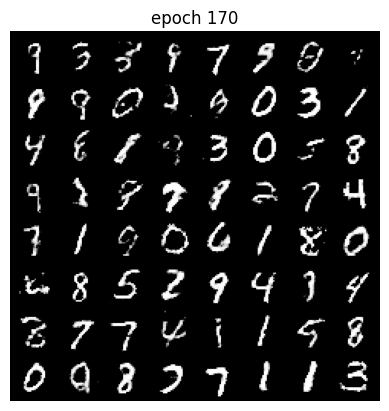

Epoch 170 of 200
Generator loss: 1.03957919, Discriminator loss: 1.20695146


469it [00:19, 23.54it/s]                         


Epoch 171 of 200
Generator loss: 1.01571050, Discriminator loss: 1.20605906


469it [8:14:43, 63.29s/it]                               


Epoch 172 of 200
Generator loss: 1.03328810, Discriminator loss: 1.20209710


469it [00:22, 21.27it/s]                         


Epoch 173 of 200
Generator loss: 1.01643691, Discriminator loss: 1.20670135


469it [00:21, 22.01it/s]                         


Epoch 174 of 200
Generator loss: 1.02393979, Discriminator loss: 1.20392116


469it [00:21, 21.99it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


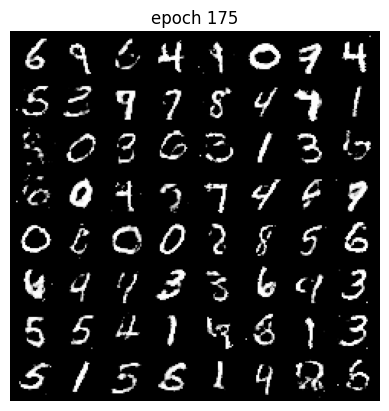

Epoch 175 of 200
Generator loss: 1.01244298, Discriminator loss: 1.20527283


469it [00:21, 22.15it/s]                         


Epoch 176 of 200
Generator loss: 1.03468347, Discriminator loss: 1.20476948


469it [00:20, 22.75it/s]                         


Epoch 177 of 200
Generator loss: 1.03259688, Discriminator loss: 1.20416812


469it [00:20, 22.93it/s]                         


Epoch 178 of 200
Generator loss: 1.04507714, Discriminator loss: 1.20030241


469it [00:20, 22.82it/s]                         


Epoch 179 of 200
Generator loss: 1.03266592, Discriminator loss: 1.20489629


469it [00:20, 22.89it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


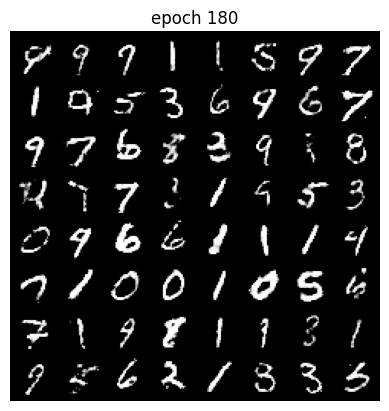

Epoch 180 of 200
Generator loss: 1.01687345, Discriminator loss: 1.21044348


469it [00:21, 22.02it/s]                         


Epoch 181 of 200
Generator loss: 1.01601875, Discriminator loss: 1.21376116


469it [00:22, 21.11it/s]                         


Epoch 182 of 200
Generator loss: 1.03756800, Discriminator loss: 1.20776090


469it [00:21, 21.73it/s]                         


Epoch 183 of 200
Generator loss: 1.01417675, Discriminator loss: 1.21116277


469it [00:21, 21.33it/s]                         


Epoch 184 of 200
Generator loss: 1.04853843, Discriminator loss: 1.19986589


469it [00:21, 21.77it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


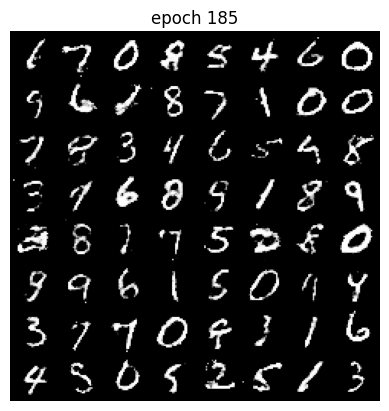

Epoch 185 of 200
Generator loss: 1.03011586, Discriminator loss: 1.20747226


469it [00:21, 21.53it/s]                         


Epoch 186 of 200
Generator loss: 1.03568782, Discriminator loss: 1.20852639


469it [00:21, 21.53it/s]                         


Epoch 187 of 200
Generator loss: 1.03050697, Discriminator loss: 1.20809092


469it [00:21, 21.82it/s]                         


Epoch 188 of 200
Generator loss: 1.03618168, Discriminator loss: 1.20163989


469it [00:21, 21.75it/s]                         


Epoch 189 of 200
Generator loss: 1.04176000, Discriminator loss: 1.19884486


469it [00:21, 21.83it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


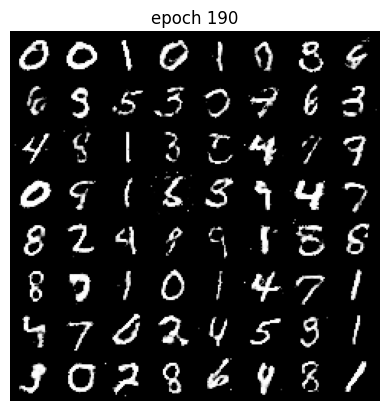

Epoch 190 of 200
Generator loss: 1.01427778, Discriminator loss: 1.20957098


469it [00:21, 21.36it/s]                         


Epoch 191 of 200
Generator loss: 1.00826278, Discriminator loss: 1.21788158


469it [00:21, 21.77it/s]                         


Epoch 192 of 200
Generator loss: 1.03356063, Discriminator loss: 1.20736081


469it [00:21, 21.76it/s]                         


Epoch 193 of 200
Generator loss: 1.02222316, Discriminator loss: 1.20811433


469it [00:21, 21.79it/s]                         


Epoch 194 of 200
Generator loss: 1.02208253, Discriminator loss: 1.20749066


469it [00:21, 21.81it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


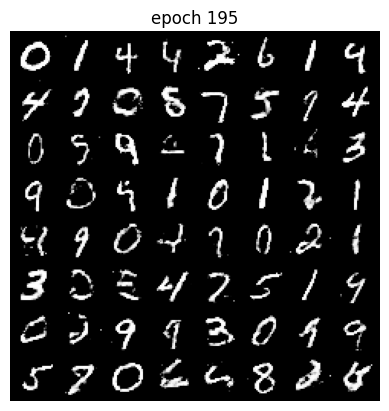

Epoch 195 of 200
Generator loss: 1.03715542, Discriminator loss: 1.20170825


469it [00:21, 21.71it/s]                         


Epoch 196 of 200
Generator loss: 1.01808395, Discriminator loss: 1.21228667


469it [00:21, 21.96it/s]                         


Epoch 197 of 200
Generator loss: 1.04318072, Discriminator loss: 1.20273974


469it [00:21, 22.10it/s]                         


Epoch 198 of 200
Generator loss: 1.00779606, Discriminator loss: 1.21546413


469it [00:21, 22.13it/s]                         


Epoch 199 of 200
Generator loss: 1.02841920, Discriminator loss: 1.20981659


469it [00:22, 20.91it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


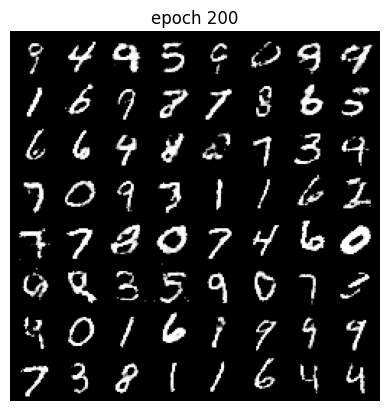

Epoch 200 of 200
Generator loss: 1.00967561, Discriminator loss: 1.20888584


In [147]:
torch.manual_seed(7777)

# Parts A and B. Part c is in gan-modified.ipynb.
part = 'A'

def generator_loss(output, true_label):
    return criterion(output, true_label)
    
# not sure if I'm implementing this in the intended way ...
def discriminator_loss(output, true_label):
    return criterion(output,true_label)
    

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/batch_size)):
        # discriminator on real images
        # log (D(x))
        discriminator.zero_grad()
        real_images = data[0].to(device)
        labels_real = label_real(real_images.size(0))
        output_real = discriminator(real_images)
        loss_real = discriminator_loss(output_real, labels_real)
        
        # discriminator on fake images
        # log(1-D(G(z)))
        noise = create_noise(real_images.size(0), nz)
        fake_images = generator(noise)
        labels_fake = label_fake(fake_images.size(0))
        output_fake = discriminator(fake_images.detach())
        loss_fake = discriminator_loss(output_fake, labels_fake)
        
        # train discriminator
        d_loss = loss_real + loss_fake
        d_loss.backward()
        optim_d.step()
        
        # train generator
        for step in range(k):
            generator.zero_grad()
            noise = create_noise(sample_size, nz)
            fake_images = generator(noise)
            output = discriminator(fake_images)
            # Part A: log(D(G(z)))
            if (part == 'A'):
                labels = label_real(sample_size)
                g_loss = generator_loss(output, labels)
            # Part B: log(1-D(G(z)))
            elif (part == 'B'):
                labels = label_fake(sample_size)
                g_loss = -generator_loss(output, labels)

            g_loss.backward()
            optim_g.step()
        
        loss_g += g_loss.item()
        loss_d += d_loss.item()
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs2/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [148]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs2/generator.pth')

DONE TRAINING


In [149]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs2/generator_images.gif', imgs)

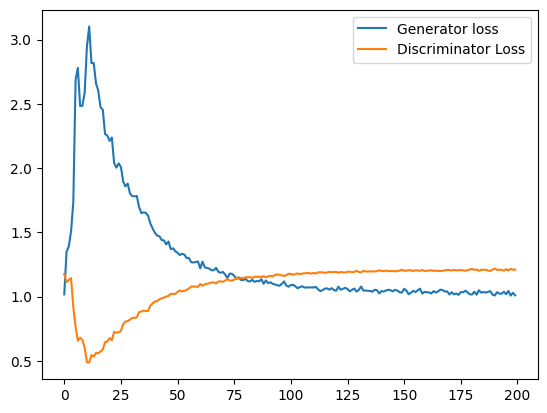

In [150]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs2/loss.png')